<h1>Importing libraries</h1>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import datetime

<h1>Pre-Processing</h1>

In [8]:
df = pd.read_csv('NVDA_history.csv')
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')  
df = df.sort_values('Date') #Sort by date
df['Volume'] = df['Volume'].str.replace(',', '').astype(int) #Convert volume to int

<h1>Exploratory Data Analysis</h1>

                             Date        Open        High         Low  \
count                         250  250.000000  250.000000  250.000000   
mean   2024-11-04 09:12:57.600000  123.275880  125.645360  120.488360   
min           2024-05-07 00:00:00   87.460000   91.000000   86.620000   
25%           2024-08-06 06:00:00  113.057500  115.572500  110.700000   
50%           2024-11-02 12:00:00  123.170000  125.065000  120.030000   
75%           2025-02-04 18:00:00  136.422500  138.485000  133.252500   
max           2025-05-06 00:00:00  153.030000  153.130000  147.820000   
std                           NaN   14.823078   14.499137   14.678285   

            Close   Adj Close        Volume  
count  250.000000  250.000000  2.500000e+02  
mean   123.153840  123.135640  2.991287e+08  
min     88.750000   88.720000  1.051570e+08  
25%    113.412500  113.397500  2.185746e+08  
50%    123.620000  123.600000  2.712190e+08  
75%    135.235000  135.225000  3.503992e+08  
max    149.430000  1

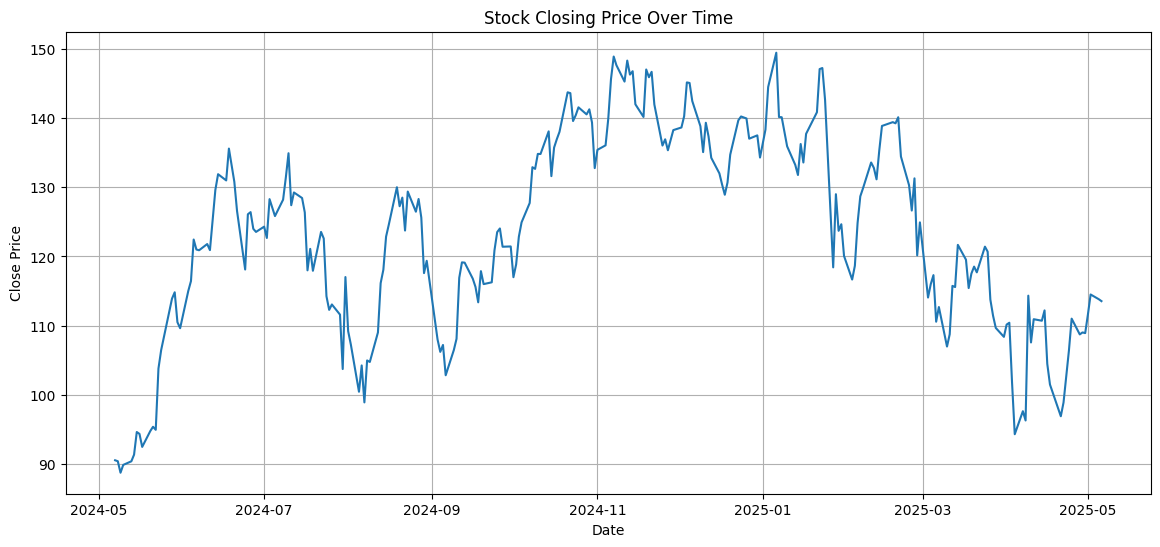

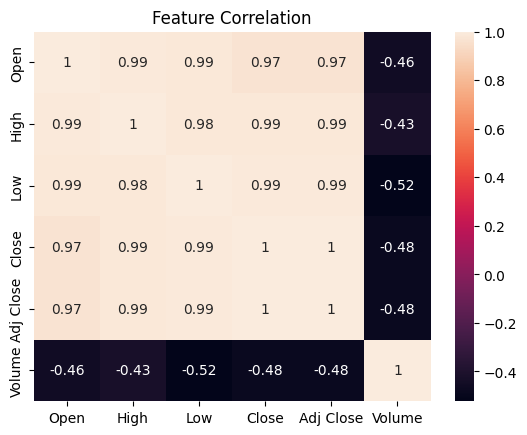

In [9]:
print(df.describe())
print(df.info())

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'])
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.show()

sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

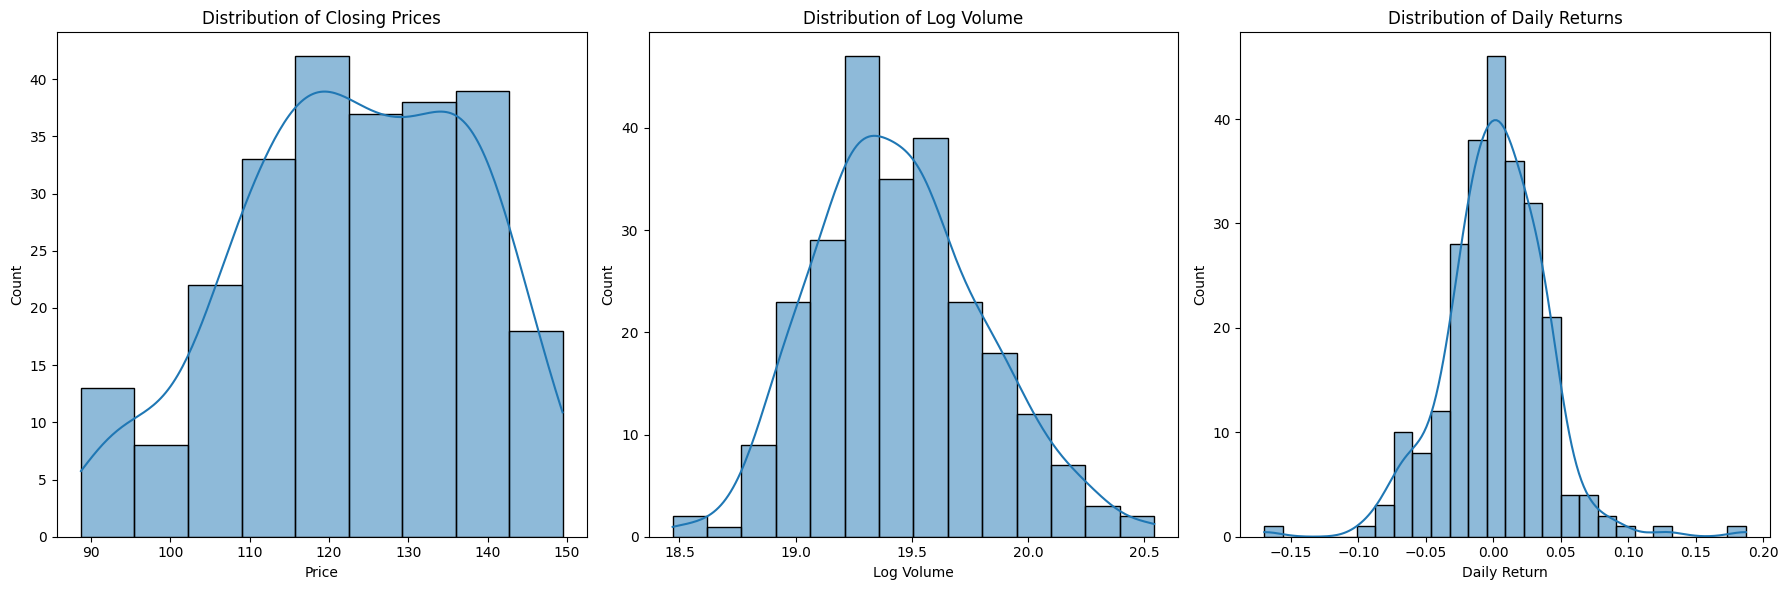

In [22]:

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for horizontal stretching

# 1. Closing price distribution
sns.histplot(df['Close'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Closing Prices')
axes[0].set_xlabel('Price')

# 2. Volume distribution (log scale)
sns.histplot(np.log(df['Volume']), kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log Volume')
axes[1].set_xlabel('Log Volume')

# 3. Daily returns
df['Daily_Return'] = df['Close'].pct_change()
sns.histplot(df['Daily_Return'].dropna(), kde=True, ax=axes[2])
axes[2].set_title('Distribution of Daily Returns')
axes[2].set_xlabel('Daily Return')

# Adjust layout
plt.tight_layout()
plt.show()

<h1>Feature Engineering</h1>

In [11]:
# Create average price and extract date parts
df['AvgPrice'] = (df['Open'] + df['High'] + df['Low']) / 3
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Refined features (drop multicollinear ones and weakly correlated)
features = ['AvgPrice', 'Day', 'Month', 'Year']
X = df[features]
y = df['Close']

<h1>Preparing the train-test split</h1>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h1>Model Testing and Metrics</h1>

In [13]:
# Step 6: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("LR R2 Score:", r2_score(y_test, y_pred_lr))

# Step 7: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF R2 Score:", r2_score(y_test, y_pred_rf))

# Step 8: Support Vector Regressor
svr = SVR(kernel='rbf', C=100)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
print("SVR R2 Score:", r2_score(y_test, y_pred_svr))

LR R2 Score: 0.8556982161297392
RF R2 Score: 0.7972920517115207
SVR R2 Score: 0.44843543679233655


<h1>Predicting Tommorow's Closing Price</h1>

In [14]:
# Final Step: Predict Tomorrow's Close
latest_data = np.array([X.iloc[-1]])
latest_scaled = scaler.transform(latest_data)
pred_tomorrow_lr = lr.predict(latest_scaled)
pred_tomorrow_rf = rf.predict(latest_data)
pred_tomorrow_svr = svr.predict(latest_scaled)

print("Predicted Close Price (Linear Regression):", pred_tomorrow_lr[0])
print("Predicted Close Price (Random Forest):", pred_tomorrow_rf[0])
print("Predicted Close Price (SVR):", pred_tomorrow_svr[0])


Predicted Close Price (Linear Regression): 113.38077032748714
Predicted Close Price (Random Forest): 113.82519999999995
Predicted Close Price (SVR): 115.4155930794507


C:\Users\asus\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\asus\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<h1>Predicting With Regularization Techniques</h1>

In [15]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

alphas   = np.logspace(-3, 3, 7)
l1_ratios = [0.1, 0.5, 0.9]

# Ridge
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_scaled, y_train)
print("Ridge R2 (test):", r2_score(y_test, ridge.predict(X_test_scaled)))

# Lasso
lasso = LassoCV(alphas=alphas, cv=5, max_iter=5000)
lasso.fit(X_train_scaled, y_train)
print("Lasso R2 (test):", r2_score(y_test, lasso.predict(X_test_scaled)))

# ElasticNet
enet = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=5000)
enet.fit(X_train_scaled, y_train)
print("ElasticNet R2 (test):", r2_score(y_test, enet.predict(X_test_scaled)))

# Predict tomorrow's close
pred_ridge   = ridge.predict(latest_scaled)[0]
pred_lasso   = lasso.predict(latest_scaled)[0]
pred_enet    = enet.predict(latest_scaled)[0]

print("Predicted Close (Ridge):", pred_ridge)
print("Predicted Close (Lasso):", pred_lasso)
print("Predicted Close (ElasticNet):", pred_enet)

Ridge R2 (test): 0.8556313049203341
Lasso R2 (test): 0.858481884604775
ElasticNet R2 (test): 0.8546151901301697
Predicted Close (Ridge): 113.38680885979454
Predicted Close (Lasso): 113.03089133125519
Predicted Close (ElasticNet): 113.46750153145227
